In [281]:
# Importing Packages 
import pandas as pd
import numpy as np
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from boruta import BorutaPy

# Objectives
#### 1. Identify significant variables that contribute to customer churn
#### 2. Predict future chrun rate using the developed model

In [282]:
# Import the dataset
data = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [283]:
# Visual inspection of data
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [284]:
# Checking for missing data
data.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [285]:
# Removing ID
data.drop("customerID", inplace = True, axis = 1)

In [286]:
# Checking Datatypes
data.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [287]:
# Cleaning up the datatypes
from sklearn.preprocessing import LabelEncoder
for c in data:
    if data[c].dtype != np.number:
        data[c] = LabelEncoder().fit_transform(data[c])
        

C:\Users\User\AppData\Local\Temp\ipykernel_10316\96946756.py:4: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if data[c].dtype != np.number:


In [288]:
# Checking Datatypes
data.dtypes

gender                int32
SeniorCitizen         int64
Partner               int32
Dependents            int32
tenure                int64
PhoneService          int32
MultipleLines         int32
InternetService       int32
OnlineSecurity        int32
OnlineBackup          int32
DeviceProtection      int32
TechSupport           int32
StreamingTV           int32
StreamingMovies       int32
Contract              int32
PaperlessBilling      int32
PaymentMethod         int32
MonthlyCharges      float64
TotalCharges          int32
Churn                 int32
dtype: object

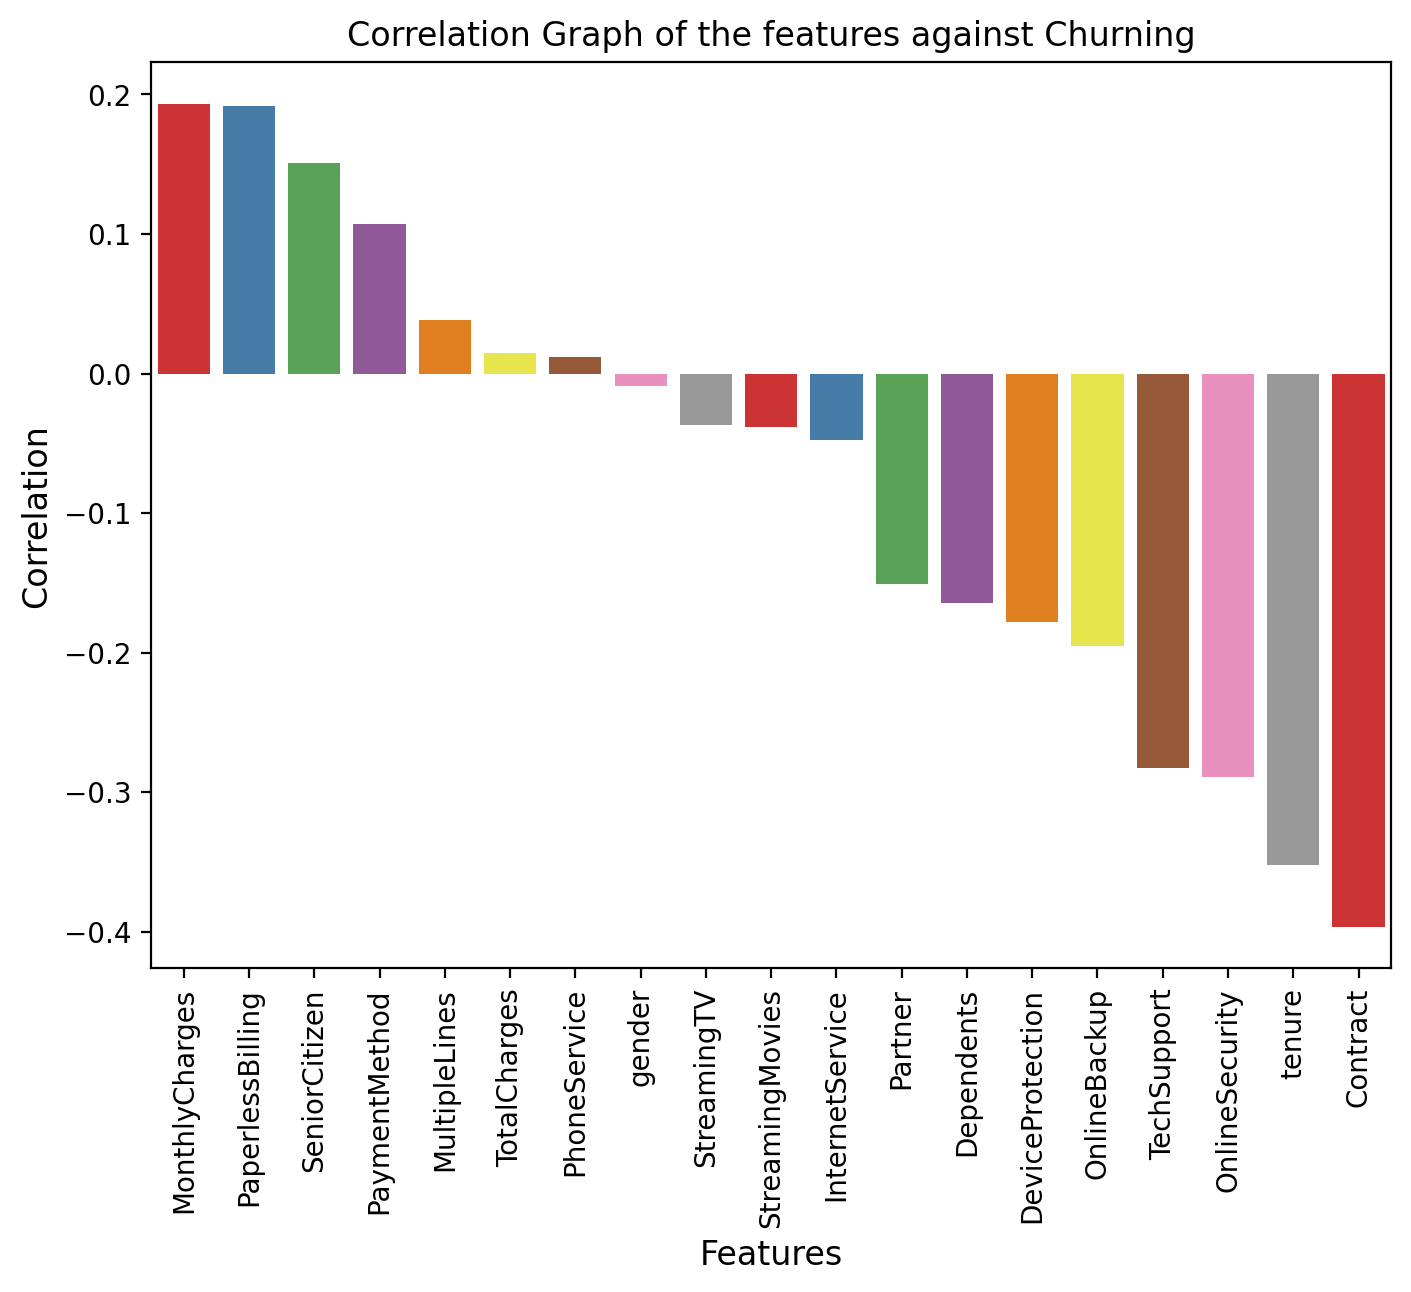

In [289]:
# Barplot of the correlated features
values = data.corr()['Churn'].sort_values(ascending=False)[1:].values
index = data.corr()['Churn'].sort_values(ascending=False)[1:].index

# Create Plot
fig, ax = plt.subplots(figsize=(8, 6), dpi=200)
sns.barplot(x=index, y=values, palette='Set1',ax=ax)
plt.xticks(rotation=90)
plt.title('Correlation Graph of the features against Churning')
plt.ylabel('Correlation', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.show()

In [290]:
# Getting the correlation for features
churn_series = data['Churn']
corr_data = []
for f in data.columns:
    corr_data.append([f,np.corrcoef(data[f],churn_series)[0][1]])
corr_data.sort(key = lambda x : x[1])
corr_data

[['Contract', -0.39671262920984235],
 ['tenure', -0.3522286701130779],
 ['OnlineSecurity', -0.28930899612232425],
 ['TechSupport', -0.28249160820465163],
 ['OnlineBackup', -0.19552501409217646],
 ['DeviceProtection', -0.17813386106687648],
 ['Dependents', -0.16422140157972498],
 ['Partner', -0.15044754495917664],
 ['InternetService', -0.047291387683142366],
 ['StreamingMovies', -0.038491628519887355],
 ['StreamingTV', -0.03658099337318671],
 ['gender', -0.008612095078997864],
 ['PhoneService', 0.01194198002900294],
 ['TotalCharges', 0.014478977600651788],
 ['MultipleLines', 0.0380368856061871],
 ['PaymentMethod', 0.1070620058734036],
 ['SeniorCitizen', 0.1508893281764732],
 ['PaperlessBilling', 0.19182533166646806],
 ['MonthlyCharges', 0.19335642223784705],
 ['Churn', 1.0]]

In [291]:
# Only consider important features
# get data above certain value
corr_value_baseline = 0.2 # need to make dynamic
features_tostay = list(filter(lambda x : abs(x[1]) > corr_value_baseline, corr_data))
features_tostay.remove(['Churn', 1.0])

features_tostay = list(map(lambda x:x[0], features_tostay))
X = data[features_tostay]
y = data['Churn']

In [292]:
# Standardisation
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X)
X = pd.DataFrame(X)

In [293]:
# Provides train/test indices to split data in train/test sets.
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [294]:
#Provides train/test indices to split data in train/test sets.
ksf=sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=None)

for train_index,test_index in ksf.split(X,y):
  X_train, X_test = X.iloc[train_index,:],X.iloc[test_index,:]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [295]:
# Create the model.
model = sklearn.linear_model.LogisticRegression()
# Train the model.
model.fit(X_train, y_train)

LogisticRegression()

In [296]:
predictions = model.predict(X_test)
predictions

array([1, 0, 0, ..., 0, 0, 1])

In [297]:
# Classification Report
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1034
           1       0.63      0.55      0.59       374

    accuracy                           0.80      1408
   macro avg       0.74      0.72      0.73      1408
weighted avg       0.79      0.80      0.79      1408



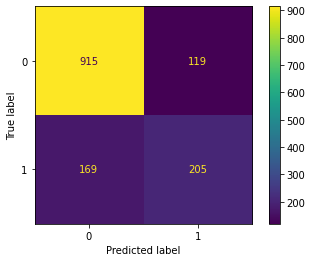

In [298]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
# Confusion Matrix 
cm = confusion_matrix(y_test, predictions)
display = ConfusionMatrixDisplay(cm)
display.plot()
plt.show()